In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from RediCell import *
from DesignTool import *

Sides are [128  64  64] with spacing of 1.6e-08 m (3 dimensions).
Overall system sizes are [2.048e-06 1.024e-06 1.024e-06] m
Voxel [64 32 32] has a coordinate of [0.00000000e+00 1.05879118e-22 1.05879118e-22]
Voxel [101, 32, 32] has a coordinate of [5.92000000e-07 1.05879118e-22 1.05879118e-22]
Voxel [27, 32, 32] has a coordinate of [-5.92000000e-07  1.05879118e-22  1.05879118e-22]
Successfully created a E. coli rod


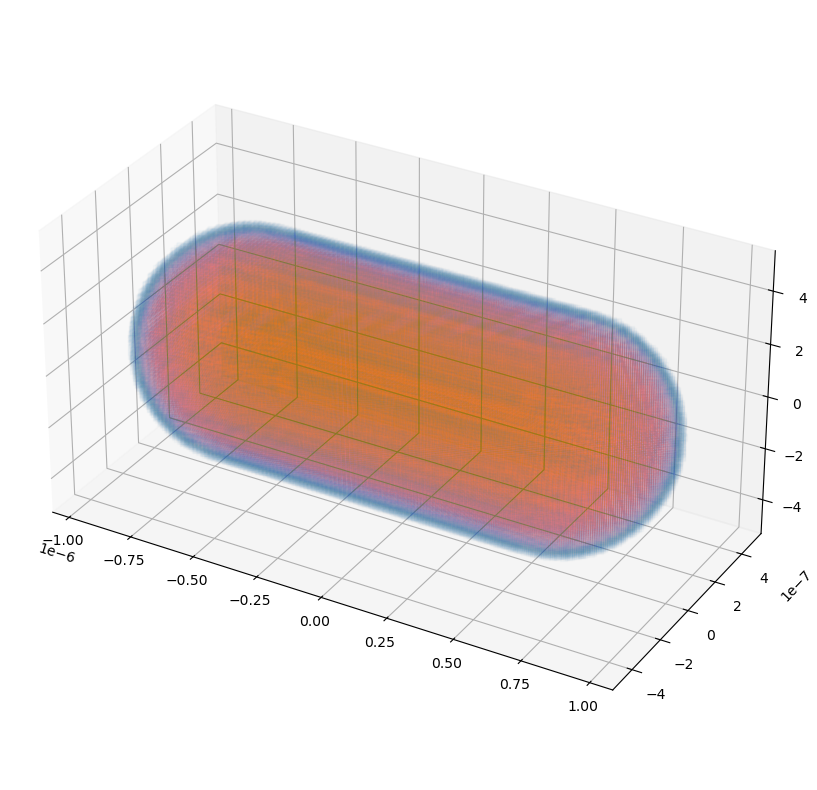

In [82]:
d = DesignTool()
d.get_blanket_space([128, 64, 64], spacing=16e-9)
d.add_ecoli_rod(l=2e-6, r=0.4e-6, barrier_type=1, space_type=1, offsety=0)#, offsety=1.6e-7)
d.set_border_wall()
%matplotlib inline
d.draw3D(exclude_barrier_type=[0], exclude_space_type=[0])


In [3]:
mol_A = Molecule('A', diffusion_coefficient=8.15e-14, observed_barrier_types=2)
mol_B = Molecule('B', diffusion_coefficient=8.15e-14, observed_barrier_types=[1, 2])
mol_C = Molecule('C', diffusion_coefficient=8.15e-14, observed_barrier_types=[1, 2])
molset = MoleculeSet([mol_A, mol_B, mol_C])

In [4]:
rxset = ReactionSet()
rxset.add_reaction(['A', 'B'], ['C'], 1.07e5)
rxset.add_reaction(['C'], ['A', 'B'], 0.351)

In [58]:
a = RediCell(design=d, molecule_types=molset, reaction_set=rxset, t_step=2e-3)

In [59]:
a_supply_matrix = np.zeros(a.true_sides)
a_supply_matrix[(a.special_space_type == 0) * (a.barrier_type == -1)] = 1
# a_supply_matrix[1:-1, 1:-1, [1, -2]] = 1
# a_supply_matrix[1:-1, [1, -2], 1:-1] = 1
# a_supply_matrix[[1, -2], 1:-1, 1:-1] = 1

a.add_external_conditions(a_supply_matrix, mol_A, 10)
a.show_external_conditions()

Maintain 10 micromolar of A within a space of 302767 voxels (7469 molecules)


In [60]:
a.partition()

[[0, 1], [2]]
Action list:
Diffusion of A (6 directions)
Diffusion of B (6 directions)
Diffusion of C (6 directions)
Reaction: reagent ['A', 'B'] -> product ['C']
Reaction: reagent ['C'] -> product ['A', 'B']


In [61]:
a.configure_barrier()

In [62]:
a.maintain_external_conditions()

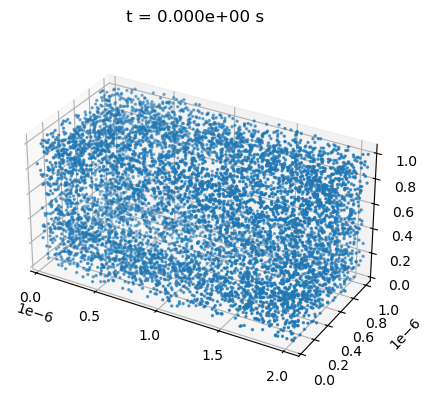

In [63]:
a.plot3D(['A'], wall=False)

In [64]:
a.voxel_matrix_shape

(3, 130, 66, 66)

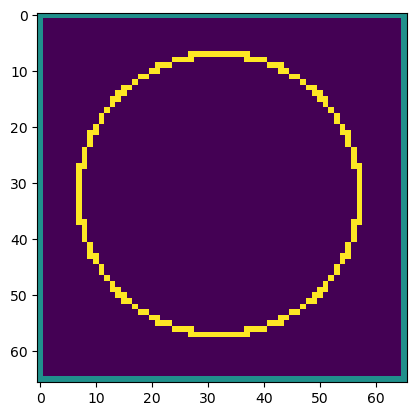

In [65]:
plt.imshow(a.barrier_type[50])

In [66]:

inner = np.where(a.special_space_type == 1)
num_voxel_inner = len(inner[0])
print(num_voxel_inner)
# Change half of that space
choice = np.random.choice(num_voxel_inner, num_voxel_inner//2, replace=False)
selection = [x[choice] for x in inner]
a.barrier_type[selection[0], selection[1], selection[2]] = 2

# place 10000 B
remaining_inner = np.where((a.special_space_type == 1) * (a.barrier_type == -1))
num_voxel_remaining_inner = len(remaining_inner[0])
print(num_voxel_remaining_inner)
choice = np.random.choice(num_voxel_remaining_inner, 10000, replace=False)
selection = [x[choice] for x in remaining_inner]
a.voxel_matrix[1, selection[0], selection[1], selection[2]] = 1

201055
100528


In [67]:
remaining_inner

(array([  3,   3,   3, ..., 125, 125, 125]),
 array([28, 28, 29, ..., 35, 36, 36]),
 array([30, 33, 30, ..., 35, 30, 33]))

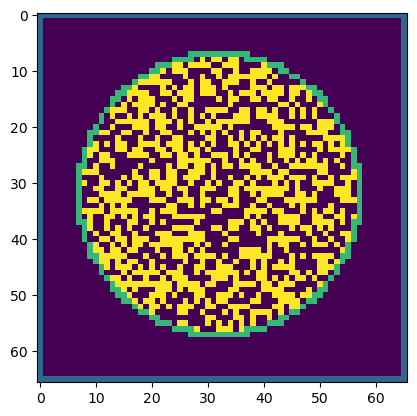

In [68]:
plt.imshow(a.barrier_type[80])

In [69]:
a.voxel_matrix[1].sum()

10000.0

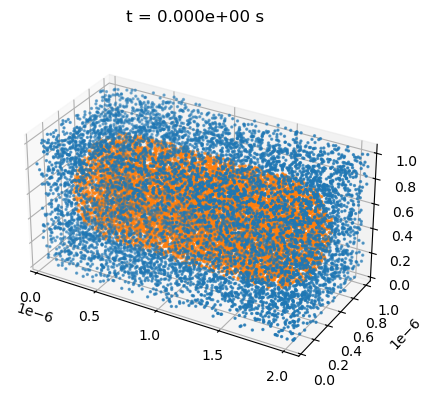

In [70]:
a.plot(['A', 'B'], wall=False)

In [71]:
a.determine_maximum_timestep()

Max time step is 7.85e-04 s (max 1.0 particles in voxel)


0.0007852760736196319

In [72]:
np.max(np.array(a.diffusion_vector)/2/a.ndim)

318.359375

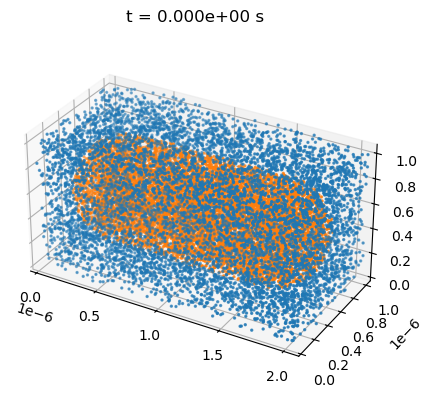

In [73]:
# a.react_diffuse(5e-4)
a.plot(['A', 'B', 'C'], wall=False)

Simulate 2000 steps
20 40 60 80 100 120 140 160 180 200 21.04 s - 105.19 ms / step
220 240 260 280 300 320 340 360 380 400 41.84 s - 104.59 ms / step
420 440 460 480 500 520 540 560 580 600 62.73 s - 104.55 ms / step
620 640 660 680 700 720 740 760 780 800 83.48 s - 104.35 ms / step
820 840 860 880 900 920 940 960 980 1000 104.42 s - 104.42 ms / step
1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 125.23 s - 104.36 ms / step
1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 146.06 s - 104.33 ms / step
1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 166.90 s - 104.31 ms / step
1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 187.64 s - 104.25 ms / step
1820 1840 1860 1880 1900 1920 1940 1960 1980 

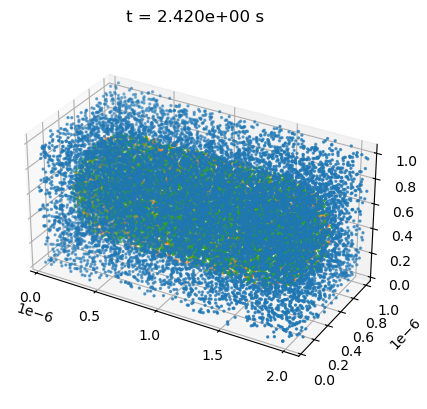

In [79]:
a.simulate(2000, t_step=6e-4, plot_every=None, timing=True)
a.plot(['A', 'B', 'C'], wall=False)

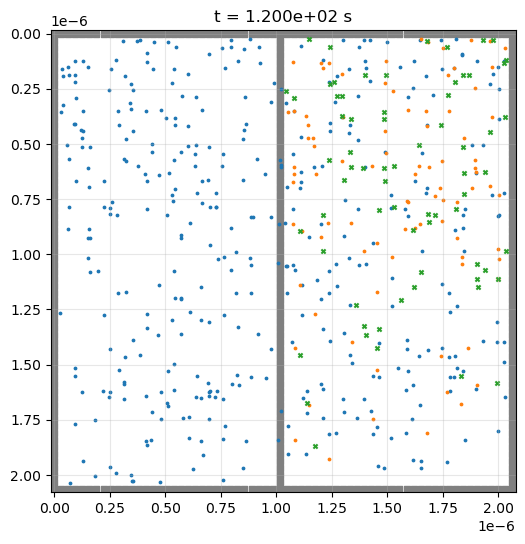

In [34]:
a.plot(['A', 'B', 'C'], wall=False)

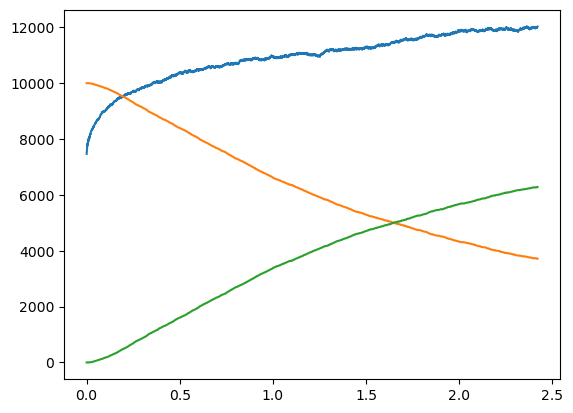

In [80]:
plt.plot(a.t_trace, np.array(a.conc_trace))
# plt.yscale('log')

In [78]:
a.one_per_voxel_equal_um * a.voxel_matrix[0].sum() / np.prod(np.array(a.voxel_matrix[0].shape) - 2)

8.523078252167553

In [54]:
np.prod(np.array(a.voxel_matrix[0].shape) - 2)

4096

In [2]:
# class RediCell:
    
#     def __init__(self, sides=None, spacing=None, t_step=None, molecule_types=None, wall=True):
#         # sides in number of voxels
#         # spacing in m
#         # "wall" adds one extra cell each direction, set as barrier
#         self.spacing = spacing
#         # Should be a list of Molecule instances
#         if isinstance(molecule_types, MoleculeSet):
#             self.molecule_types = molecule_types.molecule_types
#             self.molecule_names = molecule_types.molecule_names
#         if isinstance(molecule_types, list):
#             self.molecule_types = molecule_types
#             self.molecule_names = [mol.molecule_name for mol in self.molecule_types]
#         self.num_types = len(self.molecule_types)
#         self.mol_to_id = {mol.molecule_name: idx for idx, mol in enumerate(self.molecule_types)}
#         self.id_to_mol = {idx: mol.molecule_name for idx, mol in enumerate(self.molecule_types)}
#         self.wall = wall
#         self.initialized = False
#         self.voxel_matrix = []
#         assert len(sides) > 0 and len(sides) < 4
#         self.ndim = len(sides)
#         self.sides = np.array(sides) # Should be [32, 32] or [32, 32, 32]
        
#         if self.wall:
#             self.true_sides = self.sides + 2
#         else:
#             self.true_sides = self.sides

        
            
#         self.t_step = t_step
#         self.t_trace = []
#         self.conc_trace = []
#         self.diffusion_vector = None
#         self.reagent_vector_list = []
#         self.reaction_vector_list = []
#         self.reaction_coefficients = []
#         self.fig = None
#         self.cumulative_t = 0
#         self.reaction_set = None
#         self.num_reaction = 0
    
#         self.side_coord = [np.linspace(0, side * self.spacing, side+1) for side in self.true_sides]
#         self.mesh = np.meshgrid(*self.side_coord)
    
#     def partition(self):
#         # m, x, y matrix
#         self.voxel_matrix = np.zeros((self.num_types, *self.true_sides))

#         self.construct_possible_actions()
#         print(f'Diffusion vector is {self.diffusion_vector}')
        
#         self.diffusion_matrix = np.tile(np.expand_dims(self.diffusion_vector, tuple(range(1, self.ndim+1))), 
#                                                    (1, *self.voxel_matrix.shape[1:]))
#         if self.reaction_set is not None:
#             # self.reagent_matrix_list = [np.tile(np.expand_dims(x, tuple(range(1, self.ndim+1))), 
#             #                                            (1, *self.voxel_matrix.shape[1:])) 
#             #                              for x in self.reagent_vector_list]

#             self.reaction_matrix_list = [np.tile(np.expand_dims(x, tuple(range(1, self.ndim+1))), 
#                                                        (1, *self.voxel_matrix.shape[1:])) 
#                                          for x in self.reaction_vector_list]

#         if self.wall:
#             self.set_border_wall()
#         #self.edit_action_vector()

#     def set_border_wall(self): 
#         self.not_barrier_matrix = np.ones(self.true_sides)
#         if self.ndim >= 1:
#             self.not_barrier_matrix[0] = 0
#             self.not_barrier_matrix[-1] = 0
#         if self.ndim >= 2:
#             self.not_barrier_matrix[:, 0] = 0
#             self.not_barrier_matrix[:, -1] = 0
#         if self.ndim >= 3:
#             self.not_barrier_matrix[:, :, 0] = 0
#             self.not_barrier_matrix[:, :, -1] = 0            
    
#     def plot_wall(self):
#         plt.imshow(self.not_barrier_matrix, cmap='Oranges_r', vmax=1, vmin=0)
        
#     def initialize(self):
#         assert self.initialized == False
#         # Set condition based on initial conditions
#         # Set external conditions
#         # Compile all possible reactions (diffuse to 4 neighbors, reactions, and do nothing)
#         # Calculate largest possible timestep
#         self.initialized = True

#     def add_reaction_set(self, reaction_set=None):
#         self.reaction_set = reaction_set
#         self.num_reaction = len(self.reaction_set.reaction)
    
#     def list_reaction_set(self):
#         pass
    
#     def construct_possible_actions(self):
#         # up, down, left, right for each kind of molecule
#         # then reactions
#         diffusion_vector = []
#         self.reagent_vector_list = []
#         self.reaction_vector_list = []
#         self.reaction_coefficients = []
#         for mol in self.molecule_types:
#             for direction in range(self.ndim*2): # up down left right
#                 # this results in unit of second per molecule
#                 diffusion_vector.append(mol.diffusion_coefficient / self.spacing**2) 
#         self.diffusion_vector = np.array(diffusion_vector)
        
#         if self.reaction_set is not None:
#             for reaction in self.reaction_set.reaction:
#                 reagent_vector = []
#                 reaction_vector = np.zeros(self.num_types)
#                 for reagent in reaction[0]: # Should be names of the reagents
#                     reagent_vector.append(self.mol_to_id[reagent])
#                     reaction_vector[self.mol_to_id[reagent]] = -1
#                 for product in reaction[1]:
#                     reaction_vector[self.mol_to_id[product]] = 1
#                 self.reagent_vector_list.append(reagent_vector)
#                 self.reaction_vector_list.append(reaction_vector.astype(int))
#                 self.reaction_coefficients.append(reaction[2])
#             print(self.reagent_vector_list)
        
#         print('Action list:')
#         for mol in self.molecule_types:
#             print(f'Diffusion of {mol.molecule_name} ({self.ndim*2} directions)')
#         if self.reaction_set is not None:
#             for reaction in self.reaction_set.reaction:
#                 print(f'Reaction: reagent {reaction[0]} -> product {reaction[1]}')
#         else:
#             print('No reactions')
    
#     def determine_maximum_timestep(self):
#         print(f'Max time step is {1 / np.max(self.diffusion_vector) / 4 / self.voxel_matrix.max() :.2e} s (max {self.voxel_matrix.max()} particles in voxel)')
#         return 1 / np.max(self.diffusion_vector) / 4 / self.voxel_matrix.max()
        
#     def add_molecules(self, molecule_type, molecule_count):
#         self.molecule_count[molecule_type] = molecule_count
#         # distribute molecules randomly
#         pass

#     def maintain_external_conditions(self):
#         pass

#     def react_diffuse(self, t_step):
        
#         pad = np.zeros((self.ndim+1, 2)).astype(int)
#         pad[0, 1] += 1
        
#         # Diffuse part
#         diffuse_voxel = np.repeat(self.voxel_matrix, 2*self.ndim, axis=0) 
#         diffuse_voxel *= self.diffusion_matrix[:2*self.ndim*self.num_types] * t_step
#         diffuse_candidate = np.cumsum(diffuse_voxel, axis=0)
#         diffuse_candidate = np.pad(diffuse_candidate, pad_width=pad, constant_values=1)
#         no_diffusion_choice_idx = len(diffuse_candidate) - 1
#         if diffuse_candidate[-2].max() > 1:
#             print('Warning: transition probability > 1')
#         random_sampling = np.random.random(self.true_sides)
#         diffusion_choice = np.argmax(random_sampling < diffuse_candidate, axis=0)
#         no_diffusion_voxel = (diffusion_choice == no_diffusion_choice_idx)
#         # print(np.sum(no_action_voxel))

#         # Could use this to skip actions but ... doesn't seem like much help
#         # action_count = np.bincount(action_choice.flatten())
        
#         # React part
#         if self.reaction_set is not None:
#             reaction_voxel = np.zeros((self.num_reaction, *self.true_sides))
#             for idx, (reagent, coeff) in enumerate(zip(self.reagent_vector_list, self.reaction_coefficients)):
#                 # Only if no diffusion happened there - guarantees no negative mol count
#                 if len(reagent) == 2:
#                     reaction_voxel[idx] = 1 - np.exp(-np.prod(self.voxel_matrix[reagent], axis=0) * coeff / 6.023e23 / self.spacing**3 / 1000 * t_step)
#                 if len(reagent) == 1:
#                     reaction_voxel[idx] = 1 - np.exp(-np.prod(self.voxel_matrix[reagent], axis=0) * coeff * t_step)
                
#             # if reaction_voxel.max() > 0:
#             #     print(self.voxel_matrix[reagent].shape, reaction_voxel.max(axis=(1, 2, 3)), coeff, t_step)                
            
#             reaction_candidate = np.cumsum(reaction_voxel, axis=0)
#             reaction_candidate = np.pad(reaction_candidate, pad_width=pad, constant_values=1)
#             random_sampling = np.random.random(self.true_sides)
#             reaction_choice = np.argmax(random_sampling < reaction_candidate, axis=0)
#             # print(np.sum(reaction_choice == 0))
        
        
#             # Currently only this is implemented, and only diffusion
#         for choice in range(len(self.diffusion_vector)):
#             if self.ndim >= 1:
#                 if choice % (2*self.ndim) == 0: 
#                     move_action = (diffusion_choice[1:] == choice) * self.not_barrier_matrix[:-1]
#                     self.voxel_matrix[choice//(2*self.ndim), 1:] -= move_action
#                     self.voxel_matrix[choice//(2*self.ndim), :-1] += move_action
#                 if choice % (2*self.ndim) == 1:
#                     move_action = (diffusion_choice[:-1] == choice) * self.not_barrier_matrix[1:]
#                     self.voxel_matrix[choice//(2*self.ndim), :-1] -= move_action
#                     self.voxel_matrix[choice//(2*self.ndim), 1:] += move_action
#             if self.ndim >= 2:
#                 if choice % (2*self.ndim) == 2:
#                     move_action = (diffusion_choice[:, 1:] == choice) * self.not_barrier_matrix[:, :-1]
#                     self.voxel_matrix[choice//(2*self.ndim), :, 1:] -= move_action
#                     self.voxel_matrix[choice//(2*self.ndim), :, :-1] += move_action
#                 if choice % (2*self.ndim) == 3:
#                     move_action = (diffusion_choice[:, :-1] == choice) * self.not_barrier_matrix[:, 1:]
#                     self.voxel_matrix[choice//(2*self.ndim), :, :-1] -= move_action
#                     self.voxel_matrix[choice//(2*self.ndim), :, 1:] += move_action
#             if self.ndim >= 3:
#                 if choice % (2*self.ndim) == 4:
#                     move_action = (diffusion_choice[:, :, 1:] == choice) * self.not_barrier_matrix[:, :, :-1]
#                     self.voxel_matrix[choice//(2*self.ndim), :, :, 1:] -= move_action
#                     self.voxel_matrix[choice//(2*self.ndim), :, :, :-1] += move_action
#                 if choice % (2*self.ndim) == 5:
#                     move_action = (diffusion_choice[:, :, :-1] == choice) * self.not_barrier_matrix[:,  :, 1:]
#                     self.voxel_matrix[choice//(2*self.ndim), :, :, :-1] -= move_action
#                     self.voxel_matrix[choice//(2*self.ndim), :, :, 1:] += move_action
            
#         if self.reaction_set is not None:
#             for choice in range(self.num_reaction):
#                 # print(self.voxel_matrix.shape, self.reaction_matrix_list[choice].shape, no_diffusion_voxel.shape, reaction_choice.shape)
#                 self.voxel_matrix += self.reaction_matrix_list[choice] * no_diffusion_voxel * (reaction_choice == choice)
                    
#         self.cumulative_t += t_step
#         self.t_trace.append(self.cumulative_t)
#         self.conc_trace.append(self.voxel_matrix.sum(tuple(range(1, self.ndim+1))))
                
#     def simulate(self, steps, t_step=None, plot_every=None, timing=False):
#         if not self.initialized:
#             self.initialize()
#         if t_step is not None:
#             self.t_step = t_step
#         for step in range(steps):
#             if step == 0: 
#                 t0 = time.time()
#                 print(f'Simulate {steps} steps')
#             if steps > 100 and step % (steps // 100) == 0 and step > 0:
#                 print(step, end=' ')
#             if timing and steps > 100 and step % (steps // 10) == 0 and step > 0:
#                 t1 = time.time()
#                 print(f'{(t1 - t0):.2f} s - {(t1-t0)*1000 / step:.2f} ms / step')
                
#             self.maintain_external_conditions()
#             self.react_diffuse(self.t_step)
#             if plot_every is not None:
#                 if step % plot_every == 0:
#                     self.plot(self.molecule_names)
        
#     def plot(self, mol_type, wall=True):
#         if self.ndim == 2:
#             self.plot2D(mol_type, wall)
#         if self.ndim == 3:
#             self.plot3D(mol_type, wall)
            
#     def plot2D(self, mol_type, wall=True):
#         plt.figure(figsize=(6,6), dpi=100)
#         if type(mol_type) == str:
#             mol_type = [mol_type]
#         if wall:
#             # plot wall 
#             barrier_present = np.where(1 - self.not_barrier_matrix)
#             barrier_location = [self.mesh[x][barrier_present] for x in range(self.ndim)]
#             plt.scatter(barrier_location[0], barrier_location[1], s = 25, c = 'gray', marker='s')
#         for idx, mol in enumerate(mol_type):
#             particles_present = np.where(self.voxel_matrix[idx] > 0)
#             particle_number = self.voxel_matrix[idx][particles_present].astype(int)
#             particle_location = np.array([np.repeat(self.mesh[x][particles_present], particle_number) 
#                                  for x in range(self.ndim)])
#             # randomize location a bit
#             particle_location += (np.random.random(size=particle_location.shape) - 0.5) * self.spacing * 0.5
#             if idx < 2:
#                 plt.scatter(particle_location[0], particle_location[1], s=3)
#             else:
#                 plt.scatter(particle_location[0], particle_location[1], s=9, marker='x')
#         plt.xlim([-0.5 * self.spacing, (self.true_sides[0]-0.5)*self.spacing])
#         plt.ylim([-0.5 * self.spacing, (self.true_sides[1]-0.5)*self.spacing])
#         plt.gca().invert_yaxis()
#         plt.title(f't = {self.cumulative_t:.3e} s')
#         plt.grid(alpha=0.3)
#         plt.show()

#     def plot3D(self, mol_type, wall=True):
#         fig = plt.figure()
#         ax = fig.add_subplot(projection='3d')
#         if type(mol_type) == str:
#             mol_type = [mol_type]
#         if wall:
#             # plot wall 
#             barrier_present = np.where(1 - self.not_barrier_matrix)
#             barrier_location = [self.mesh[x][barrier_present] for x in range(self.ndim)]
#             ax.scatter(barrier_location[0], barrier_location[1], barrier_location[2], s = 25, c = 'gray', marker='s')
#         for idx, mol in enumerate(mol_type):
#             particles_present = np.where(self.voxel_matrix[idx] > 0)
#             particle_number = self.voxel_matrix[idx][particles_present].astype(int)
#             particle_location = np.array([np.repeat(self.mesh[x][particles_present], particle_number) 
#                                  for x in range(self.ndim)])
#             # randomize location a bit
#             particle_location += (np.random.random(size=particle_location.shape) - 0.5) * self.spacing * 0.5
#             if idx < 2:
#                 ax.scatter(particle_location[0], particle_location[1], particle_location[2], s=3)
#             else:
#                 ax.scatter(particle_location[0], particle_location[1], particle_location[2], s=9, marker='x')    
#         ax.set_xlim([-0.5 * self.spacing, (self.true_sides[0]-0.5)*self.spacing])
#         ax.set_ylim([-0.5 * self.spacing, (self.true_sides[1]-0.5)*self.spacing])
#         ax.set_zlim([-0.5 * self.spacing, (self.true_sides[2]-0.5)*self.spacing])
#         plt.title(f't = {self.cumulative_t:.3e} s')
#         plt.grid(alpha=0.3)
#         plt.show()

# class Voxel:
#     def __init__(self, molecule_count=[], spacing=None, is_barrier=False, action_vector=None):
#         self.molecule_count = molecule_count
#         self.is_barrier = is_barrier
#         self.spacing = spacing
#         self.action_vector = action_vector
#     def add_molecule(self, molecule_type, molecule_count):
#         self.molecule_count[molecule_type] += molecule_count
#     def set_molecule(self, molecule_type, molecule_count):
#         self.molecule_count[molecule_type] = molecule_count
#     def compute_transition_vector(self, t):
#         return np.pad(np.cumsum(np.repeat(self.molecule_count, 4) * self.action_vector * t), (0, 1), constant_values=1)
#     def determine_action(self, t):
#         transition_vector = self.compute_transition_vector(t)
#         if np.sum(transition_vector[-2]) > 1:
#             print('Warning: transition probability > 1')
#         return np.argmax(np.random.random() < transition_vector)

# class MoleculeSet:
#     def __init__(self, molecule=[]):
#         self.molecule_types = list(molecule)
#         self.molecule_names = [mol.molecule_name for mol in self.molecule_types]
        
#     def add_molecule(self, molecule):
#         assert molecule.molecule_name not in self.molecule_names
#         self.molecule_types.append(molecule)
        
# class Molecule:
#     def __init__(self, molecule_name, diffusion_coefficient):
#         # diffusion_coefficient in m^2 / s, so a value like 1e-13 m^2/s is likely
#         self.molecule_name = molecule_name
#         self.diffusion_coefficient = diffusion_coefficient

# class ReactionSet:
#     def __init__(self):
#         self.reaction = []
#     def add_reaction(self, reagent, product, reaction_coefficient):
#         # reagent can be [typeA, typeB] for bimolecular reaction
#         # or [typeA] or typeA for unimolecular reaction
#         self.reaction.append([reagent, product, reaction_coefficient])
        